<a href="https://colab.research.google.com/github/augustinechang1/reinforcement-learning-stock-trade/blob/master/qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random


Using TensorFlow backend.


Reinforcement Learning & Q Learning Algorithms

https://towardsdatascience.com/reinforcement-learning-with-python-8ef0242a2fa2
https://keon.io/deep-q-learning/
https://medium.freecodecamp.org/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe
https://shuaiw.github.io/2018/02/11/teach-machine-to-trade.html
https://www.intel.ai/demystifying-deep-reinforcement-learning/#gs.aunwpv

Code Reference

https://github.com/augustinechang1/q-trader/blob/master/train.py
https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/agent/5.q-learning-agent.ipynb

In [5]:
!pip install alpha_vantage

In [0]:
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt

In [7]:
ts = TimeSeries(key='X5AYBIDIH2EVGNW9', output_format='pandas')
stock, meta_data = ts.get_daily(symbol='DJIA', outputsize='full')
stock = stock['4. close']
df = pd.DataFrame({'Date':stock.index, 'Close':stock.values})
df.head()

,Date,Close
0,2000-01-03,11357.5098
1,2000-01-04,10997.9297
2,2000-01-05,11122.6504
3,2000-01-06,11253.2598
4,2000-01-07,11522.5596


In [8]:
df.iloc[-1:]

,Date,Close
4873,2019-05-17,25764.0


In [0]:
#Set Index Datetime
def equalizestock(time):
#     time.index = pd.to_datetime(time.index)
    if time.index.name != 'Date':
        time = time.set_index('Date')
        time = time.loc['2018-05-10':'2019-05-10']
        return time
    else:
        time = time.loc['2018-05-10':'2019-05-10']
        return time

In [0]:
stock = equalizestock(df)

In [55]:
stock.head()

,Close
Date,
2018-05-10,24739.5293
2018-05-11,24831.1699
2018-05-14,24899.4102
2018-05-15,24706.4102
2018-05-16,24768.9297


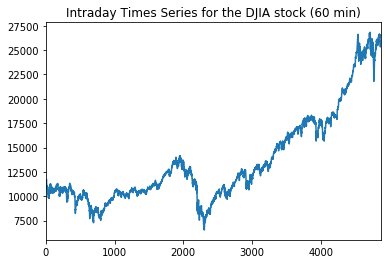

In [56]:
df['Close'].plot()
plt.title('Intraday Times Series for the DJIA stock (60 min)')
plt.show()

In [0]:
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

In [0]:
class Agent:
	def __init__(self, state_size, is_eval=False, model_name=""):
		self.state_size = state_size # normalized previous days
		self.action_size = 3 # sit, buy, sell
		self.memory = deque(maxlen=1000)
		self.inventory = []
		self.model_name = model_name
		self.is_eval = is_eval

		self.gamma = 0.95
		self.epsilon = 1.0
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.995

		self.model = load_model("models/" + model_name) if is_eval else self._model()

	def _model(self):
		model = Sequential()
		model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
		model.add(Dense(units=32, activation="relu"))
		model.add(Dense(units=8, activation="relu"))
		model.add(Dense(self.action_size, activation="linear"))
		model.compile(loss="mse", optimizer=Adam(lr=0.001))

		return model

	def act(self, state):
		if not self.is_eval and np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)

		options = self.model.predict(state)
		return np.argmax(options[0])

	def expReplay(self, batch_size):
		mini_batch = []
		l = len(self.memory)
		for i in range(l - batch_size + 1, l):
			mini_batch.append(self.memory[i])

		for state, action, reward, next_state, done in mini_batch:
			target = reward
			if not done:
				target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

			target_f = self.model.predict(state)
			target_f[0][action] = target
			self.model.fit(state, target_f, epochs=1, verbose=0)

		if self.epsilon > self.epsilon_min:
			self.epsilon *= self.epsilon_decay

In [0]:
# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(key):
	vec = []
	lines = open("data/" + key + ".csv", "r").read().splitlines()

	for line in lines[1:]:
		vec.append(float(line.split(",")[4]))

	return vec

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):
	d = t - n + 1
	block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
	res = []
	for i in range(n - 1):
		res.append(sigmoid(block[i + 1] - block[i]))

	return np.array([res])

In [19]:
# from agent.agent import Agent
# from functions import *
import sys

# if len(sys.argv) != 4:
# 	print ("Usage: python train.py [stock] [window] [episodes]")
# 	exit()
data = stock.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
episode_count = 200
# stock_name, window_size, episode_count = sys.argv[1], int(sys.argv[2]), int(sys.argv[3])

agent = Agent(window_size)
# data = getStockDataVec(stock_name)
l = len(data) - 1
batch_size = 32

for e in range(episode_count + 1):
# 	print ("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1)

	total_profit = 0
	agent.inventory = []

	for t in range(l):
		action = agent.act(state)

		# sit
		next_state = getState(data, t + 1, window_size + 1)
		reward = 0

		if action == 1: # buy
			agent.inventory.append(data[t])
			print ("Buy: " + formatPrice(data[t]))

		elif action == 2 and len(agent.inventory) > 0: # sell
			bought_price = agent.inventory.pop(0)
			reward = max(data[t] - bought_price, 0)
			total_profit += data[t] - bought_price
			print ("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

		done = True if t == l - 1 else False
		agent.memory.append((state, action, reward, next_state, done))
		state = next_state

		if done:
			print ("--------------------------------")
			print ("Total Profit: " + formatPrice(total_profit))
			print ("--------------------------------")

		if len(agent.memory) > batch_size:
			agent.expReplay(batch_size)

	if e % 10 == 0:
		agent.model.save("models/model_ep" + str(e))

Buy: $24739.53
Buy: $24706.41
Sell: $24768.93 | Profit: $29.40
Buy: $24715.09
Buy: $25013.29
Sell: $24834.41 | Profit: $128.00
Buy: $24811.76
Buy: $24415.84
Buy: $24635.21
Buy: $24813.69
Buy: $25146.39
Sell: $25316.53 | Profit: $601.44
Buy: $25322.31
Buy: $25090.48
Buy: $24987.47
Sell: $24700.21 | Profit: -$313.08
Sell: $24657.80 | Profit: -$153.96
Buy: $24461.70
Sell: $24580.89 | Profit: $165.05
Buy: $24252.80
Instructions for updating:
Use tf.cast instead.
Buy: $24117.59
Buy: $24216.05
Buy: $24271.41
Sell: $24307.18 | Profit: -$328.03
Buy: $24356.74
Buy: $24456.48
Sell: $24776.59 | Profit: -$37.10
Sell: $25019.41 | Profit: -$126.98
Buy: $25064.36
Sell: $25119.89 | Profit: -$202.42
Buy: $25199.29
Buy: $25064.50
Buy: $25058.12
Sell: $25044.29 | Profit: -$46.19
Sell: $25241.94 | Profit: $254.47
Buy: $25414.10
Sell: $25527.07 | Profit: $1065.37
Buy: $25306.83
Sell: $25415.19 | Profit: $1162.39
Buy: $25628.91
Buy: $25509.23
Sell: $25313.14 | Profit: $1195.55
Sell: $25299.92 | Profit: $108

OverflowError: ignored